In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Random Forest Anomaly Detection

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_path = '/content/drive/MyDrive/archangle-data/synthetic_mobile_money_transaction_dataset.csv'
df = pd.read_csv(data_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720181 entries, 0 to 1720180
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   step             int64  
 1   transactionType  object 
 2   amount           float64
 3   initiator        int64  
 4   oldBalInitiator  float64
 5   newBalInitiator  float64
 6   recipient        object 
 7   oldBalRecipient  float64
 8   newBalRecipient  float64
 9   isFraud          int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 131.2+ MB


In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,1544663
1,175518


In [ ]:
# percetnateg of isFraud and notIsFraud
total = 175518 + 1544663
print(175518/total * 100, "%")
print(1544663/total * 100, "%")

# unbalanced data is fraud and not is fraud

10.203461147402512 %
89.79653885259748 %


## unbalanced data handling

In [ ]:
# 50% is fraud and 50% not is fraud

fraud_df = df[df['isFraud'] == 1]
notfraud_df = df[df['isFraud'] == 0]

notfraud_sampled = notfraud_df.sample(n=len(fraud_df), random_state=42)

balanced_df = pd.concat([fraud_df, notfraud_sampled])

In [ ]:
balanced_df['isFraud'].value_counts()

,count
isFraud,
1,175518
0,175518


In [ ]:
df['transactionType'].value_counts()

,count
transactionType,
PAYMENT,667245
TRANSFER,569328
DEPOSIT,384431
WITHDRAWAL,93785
DEBIT,5392


In [ ]:
df['recipient'].value_counts()

,count
recipient,
56-0008969,400
31-0001910,395
76-0008913,383
71-0003845,382
37-0005432,382
...,...
4445726637079679,1
4410920538166567,1
4786404865288845,1


## Data Feature Statistics

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_classif

### Feature analysis by initiator

In [ ]:
list_initiator = df['initiator'].unique().tolist()

def getByInitiator(initiator):
    return df[df['initiator'] == initiator].drop('initiator', axis=1)

In [ ]:
df_1 = getByInitiator(list_initiator[0])
df_1 = df_1.drop(['transactionType', 'recipient'], axis=1)
corr = df_1.corr()

In [ ]:
# feature selection

from sklearn.preprocessing import MinMaxScaler
scaller = MinMaxScaler()

X = df_1.drop('isFraud', axis=1)
y = df_1['isFraud']

scaller.fit(X)

scaled_x = scaller.transform(X)

selector = SelectKBest(score_func=chi2, k=5)
X_new = selector.fit_transform(scaled_x, y)

X.columns[selector.get_support()]

Index(['step', 'amount', 'oldBalInitiator', 'newBalInitiator',
       'newBalRecipient'],
      dtype='object')

<Axes: >

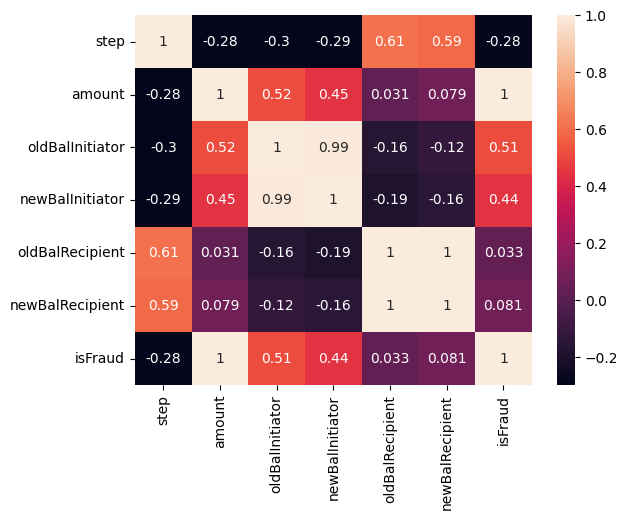

In [ ]:
sns.heatmap(corr, annot=True)

# isFraud is strongly related to amount | oldBalInitiator | newBalInitiator |

### Feature Analysis of all data

In [ ]:
# feature selection

from sklearn.preprocessing import MinMaxScaler
scaller = MinMaxScaler()

X = df.drop(['transactionType', 'initiator', 'recipient', 'isFraud'], axis=1)
y = df['isFraud']

scaller.fit(X)

X_std = scaller.transform(X)

selector = SelectKBest(score_func=chi2, k=5)
X_new = selector.fit_transform(X_std, y)

In [ ]:
selector.get_support()

array([ True,  True,  True,  True,  True, False])

In [ ]:
X.columns[selector.get_support()]

Index(['step', 'amount', 'oldBalInitiator', 'newBalInitiator',
       'oldBalRecipient'],
      dtype='object')

In [ ]:
df[['step', 'amount', 'newBalInitiator', 'oldBalRecipient']].corr()

,step,amount,newBalInitiator,oldBalRecipient
step,1.000000,-0.135595,0.092421,0.135904
amount,-0.135595,1.000000,0.063745,0.333787
newBalInitiator,0.092421,0.063745,1.000000,0.091023
oldBalRecipient,0.135904,0.333787,0.091023,1.000000


## Create and Training Model

### Training specific initiator data

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

outLier = 13 / 111

X = df_1[['step', 'amount', 'newBalInitiator', 'oldBalRecipient']]
Y = df_1['isFraud']

stdScale_by_initiator = StandardScaler()
stdScale_by_initiator.fit(X)
X_scaled = stdScale_by_initiator.transform(X)

model_by_initiator = IsolationForest(n_estimators = 100, contamination = outLier, random_state=42)
model_by_initiator.fit(X_scaled, Y)

y_pred = model_by_initiator.predict(X_scaled)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(Y, y_pred))
print("Accuracy in finding anomaly:",accuracy_score(Y,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       111
           1       0.67      0.77      0.71        13

    accuracy                           0.94       124
   macro avg       0.82      0.86      0.84       124
weighted avg       0.94      0.94      0.94       124

Accuracy in finding anomaly: 0.9354838709677419


### Training overall data

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = df[['step', 'amount', 'newBalInitiator', 'oldBalRecipient']]
Y = df['isFraud']

stdScale = StandardScaler()
stdScale.fit(X)
X_scaled = stdScale.transform(X)

model = IsolationForest(n_estimators = 100, random_state=42)
model.fit(X_scaled, Y)

y_pred = model.predict(X_scaled)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(Y, y_pred))
print("Accuracy in finding anomaly:",accuracy_score(Y,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87   1544663
           1       0.07      0.11      0.09    175518

    accuracy                           0.78   1720181
   macro avg       0.48      0.48      0.48   1720181
weighted avg       0.81      0.78      0.79   1720181

Accuracy in finding anomaly: 0.7750614615554992


# Create model pipeline

In [63]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

outLier = 13 / 111
X = df_1[['step', 'amount', 'newBalInitiator', 'oldBalRecipient']]
Y = df_1['isFraud']

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", IsolationForest(n_estimators = 100, contamination = outLier, random_state=42))
])

In [65]:
pipeline.fit(X, Y)

y_pred = pipeline.predict(X)

In [66]:
import joblib

joblib.dump(pipeline, f"isolation_forest.pkl")

['isolation_forest.pkl']

In [73]:
model = joblib.load("isolation_forest.pkl")

X_new = pd.DataFrame(
        [[1, 10, 12.0, 12.3]],
        columns=["step", "amount", "newBalInitiator", "oldBalRecipient"]
    )

prediction = model.predict(X_new)[0]
label = "Fraud" if prediction == -1 else "Not Fraud"

In [74]:
prediction, label

(np.int64(1), 'Not Fraud')